In [1]:
import pandas as pd
from datetime import datetime
from pprint import pprint as pp
import json
import os
import csv
import shutil
import numpy as np
from scipy.interpolate import interp1d
import random
import operator
import itertools
from copy import deepcopy

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
from modules.aux_functions import *
from modules.global_vars import *
from modules.reservation_management import get_reservation_code
from modules.table_manager import manage_table, write_table_data, get_table_data

In [4]:
import matplotlib.pyplot as plt   #Data visualisation libraries 
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

In [5]:
LOCAL_COMPETENCE_HOTELS = ["Axor Barajas", "Senator Barajas"]
LOCAL_HOTEL = "Melia Barajas"

In [6]:
%matplotlib inline

In [7]:
np.random.seed(583)
random.seed(352)

In [8]:
my_hotel_path = FINAL_TABLES_PATH + HOTEL + '/'
#file_name = '0_double_lodge_week_ls.json'
file_name = '21_double-superior_lodge_weekend_ls.json'
file_to_test = my_hotel_path + file_name
hotel_data = {}
ara_values = {}

In [9]:
in_folder = FINAL_CSV_PATH + "/" + HOTEL + '/'
in_csv_file = in_folder + file_name.split(".")[0] + ".csv"

df = pd.read_csv(in_csv_file, sep=';', index_col= ["p", "p0_1", "p0_2"])
hotel_data = pd.read_csv(in_csv_file, sep=';', index_col= ["p", "p0_1", "p0_2"])

del df['Unnamed: 0']
del hotel_data['Unnamed: 0']

room_type, season = operator.itemgetter(*[1, 4])(file_name.split(".")[0].split("_"))

In [10]:
hotel_data_ni = pd.read_csv(in_csv_file, sep=';')

del hotel_data_ni['Unnamed: 0']

## Funciones auxiliares

In [11]:
def get_utility(room_price, outcome):
    """Calculate the utility of a room given a specific the room price

    :param room_price: The specific price of the room
    :returns: Value of the utility
    :rtype: Integer

    """
    total_benefits = int(room_price) + ROOM_BENEFITS[room_type] - \
        ROOM_COSTS[room_type] + SEASON_BENEFITS[season]
    total_benefits *= outcome
    return total_benefits

In [12]:
def competence_data():
    """Retrieve the competence data

    :returns: Comptence prices and its correspond clients
    :rtype: Dictionary

    """
    comp_data = {}
    for indi, comp_hotel in enumerate(COMPETENCE_HOTELS):
        comp_table = FINAL_CSV_PATH + comp_hotel + '/' + file_name.split(".")[0] + ".csv"
        comp_data[comp_hotel] = pd.read_csv(comp_table, sep=';', index_col= ["p"])
        del comp_data[comp_hotel]['Unnamed: 0']
    return comp_data

In [13]:
def get_comp_price_days():
    """Retrieve the competence days per price

    :returns: Comptence days per price
    :rtype: Dictionary of dictionaries

    """    
    comp_price_days = {}
    for indi, comp_hotel in enumerate(COMPETENCE_HOTELS):
        comp_table = PRICE_DAYS_TABLES_PATH + comp_hotel + '/' + file_name
        with open(comp_table) as fp:
            comp_price_days[comp_hotel] = json.load(fp)
    
    return comp_price_days

In [14]:
def get_virtual_comp_prices(room_price):
    room_price = int(room_price)
    temp_room_prices = []
    room_prices = []
    for indi in range(len(COMPETENCE_HOTELS)):
        temp_room_prices.append([room_price - (x * UNITS) for x in range(MIN_COMP_VIRTUAL, MAX_COMP_VIRTUAL +1) if \
                                room_price - (x * UNITS) >= MIN_PRICE and room_price - (x * UNITS) < MAX_PRICE])
    
    temp_room_prices = list(itertools.product(*temp_room_prices))
    for tuple_prices in temp_room_prices:
        room_prices.append(','.join([str(x) for x in tuple_prices]))

    return room_prices

## Desarrollo del codigo para ARA

In [15]:
def get_outcome_prob(our_price, comp_prices):
    
    x_prices = [our_price] + comp_prices
    outcome_prob = lm.predict([x_prices])

    return outcome_prob[0] if outcome_prob[0] > 0 else 0

In [16]:
def get_price_probability(hotel_data, selected_price):
    """Calculate the probability that the competence chose selected_price

    :param dict_prices: Dict with the prices used by the competence
    :param selected_price: Tuple string with the selected prices for the competence
    :returns: Probability that the competence choose the selected_price
    :rtype: Double

    """

    comp_hotel_data = {}
    result = 1

    # We stract the price clients that we have used want from competence data
    for indi, hotel_name in enumerate(LOCAL_COMPETENCE_HOTELS):
        comp_hotel_data[hotel_name] = {}
        comp_hotel_data[hotel_name]['total'] = 0
        comp_hotel_data[hotel_name]['chosen'] = 0        

        for key, value in hotel_data[hotel_name].items():
            price = selected_price[indi]
            if int(key) == price:
                comp_hotel_data[hotel_name]['chosen'] += value
            comp_hotel_data[hotel_name]['total'] += value

    for hotel_name in comp_hotel_data:
        result *= comp_hotel_data[hotel_name]['chosen'] / comp_hotel_data[hotel_name]['total']

    return result

In [17]:
def generate_ara_values(hotel_data, comp_data, comp_price_days, comp_known=False):
    """Generate ARA values from the formulas

    :returns: Array with all of the ARA values
    :rtype: List

    """
    ara_values = {}
    comp_prices = {}
    for index, row in hotel_data.iterrows():
        room_price, comp_price = index[0], index[1:]
        
        outcome_prob = row['outcome_prob']
        temp_ara_val = 0
        
        for outcome in [0, 1]:
            if outcome == 1:
                if not comp_known:
                    temp_ara_val += get_utility(room_price, outcome) * \
                        outcome_prob * \
                        get_price_probability(comp_price_days, comp_price)
                else:
                    temp_ara_val += get_utility(room_price, outcome) * \
                        outcome_prob
            else:
                if not comp_known:
                    temp_ara_val -= get_utility(room_price, outcome) * \
                        (1 - outcome_prob) * \
                        get_price_probability(comp_price_days, comp_price)
                else:
                    temp_ara_val -= get_utility(room_price, outcome) * \
                        (1 - outcome_prob)
                
        if not room_price in ara_values.keys():
            ara_values[room_price] = 0
        ara_values[room_price] += temp_ara_val

    return ara_values

In [18]:
def optimal_prices(local_hotel_data, comp_known=False):

    comp_data = competence_data()
    comp_price_days = get_comp_price_days()
    ara_values = generate_ara_values(local_hotel_data, comp_data, comp_price_days, comp_known)
    pp(ara_values)
    
    #with open('test.csv', 'w') as f:
    #    for key in ara_values.keys():
    #        f.write("%s,%s\n"%(key,ara_values[key]))

    return ara_values

In [19]:
# get_comp_price_days()

## Modelo de regresión

En esta sección se utilizará un modelo de regresión para rellenar los datos que nos faltand e la tabla.

In [20]:
x = [list(index) for index, row in df.iterrows()]
y = df['outcome_prob'].values
#y=y.astype('int')

In [21]:
lm = LinearRegression()
# lm = LogisticRegression()

In [22]:
lm.fit(x,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

### Obtenemos los datos de la competencia

comp_data = competence_data()

prices = deepcopy(hotel_data)
comp_hotels_names = prices[COMPETENCE_ORDER_KEY].split(",")
prices.pop(COMPETENCE_ORDER_KEY, None)

##### Actualiza los datos de la competencia con los precios que faltan y las probabilidades
for indi, hotel_name in enumerate(COMPETENCE_HOTELS):
    for room_price in range(MIN_PRICE, MAX_PRICE, UNITS):
        room_price = str(int(room_price))
        if room_price in comp_data[hotel_name]:
            pp("Ya existe")
            continue
        else:
            comp_data[hotel_name][room_price] = {}
            temp_comp_prices = get_virtual_comp_prices(room_price)
            for comp_price in temp_comp_prices:
                comp_data[hotel_name][room_price][comp_price] = get_outcome_prob_2(room_price, comp_price)

##### Actualiza los datos de nuestro hotel con los precios que faltan y las probabilidades de la competencia
for room_price in range(MIN_PRICE, MAX_PRICE, UNITS):
    room_price = str(int(room_price))
    if room_price not in prices:
        prices[room_price] = {}
        temp_comp_prices = get_virtual_comp_prices(room_price)
        for comp_price in temp_comp_prices:
            prices[room_price][comp_price] = get_outcome_prob_2(room_price, comp_price)

# Caso 1: no tenemos los precios de la competencia

In [23]:
#comp_data_p = competence_data()
#comp_data_p

In [24]:
# pp("Axor Barajas clients with price = 100: {}".format(comp_data['Senator Barajas'].loc[100].sum()))
# pp("Axor Barajas total clients: {}".format(comp_data['Senator Barajas'].sum()))

In [25]:
ara_values = optimal_prices(hotel_data)
print(max(ara_values.items(), key=operator.itemgetter(1))[0])

{90.0: 8.40340112221981,
 100.0: 36.85177191785423,
 110.0: 53.609589662852386,
 120.0: 30.27261441450489,
 130.0: 5.9391335807629435}
110.0


# Caso 2: tenemos los precios de la competencia

In [26]:
comp_prices = [110, 100]
hotel_data_wp = pd.DataFrame(columns = ['p','p0_1','p0_2','outcome_prob'])
hotel_data_wp.set_index(['p','p0_1','p0_2'], inplace = True)

for room_price in range(MIN_PRICE, MAX_PRICE, UNITS):
    index = [room_price] + comp_prices
    index_tup = tuple(index)
    
    try:
        hotel_data_wp.loc[index_tup] =  hotel_data.loc[index_tup]['outcome_prob']
    except Exception as e:
        hotel_data_wp.loc[index_tup] = get_outcome_prob(room_price, comp_prices)

pp(hotel_data_wp)
#hotel_data_wp.to_csv("test.csv", sep=',', encoding='utf-8')

               outcome_prob
p   p0_1 p0_2              
70  110  100       0.876258
80  110  100       0.817012
90  110  100       0.757767
100 110  100       0.684534
110 110  100       0.591246
120 110  100       0.580030
130 110  100       0.520784
140 110  100       0.461538
150 110  100       0.402293
160 110  100       0.343047
170 110  100       0.283801
180 110  100       0.224556
190 110  100       0.165310
200 110  100       0.106064
210 110  100       0.046819
220 110  100       0.000000
230 110  100       0.000000
240 110  100       0.000000
250 110  100       0.000000
260 110  100       0.000000
270 110  100       0.000000
280 110  100       0.000000
290 110  100       0.000000


In [27]:
ara_values = optimal_prices(hotel_data_wp, comp_known=True)
print(max(ara_values.items(), key=operator.itemgetter(1))[0])

{70: 70.10063431634583,
 80: 73.53110320959927,
 90: 75.77665868145496,
 100: 75.29877561847354,
 110: 70.94947401320344,
 120: 75.40384456863566,
 130: 72.90974635490043,
 140: 69.23073471976748,
 150: 64.36680966323678,
 160: 58.317971185308366,
 170: 51.08421928598222,
 180: 42.665553965258304,
 190: 33.0619752231367,
 200: 22.27348305961736,
 210: 10.30007747470024,
 220: 0.0,
 230: 0.0,
 240: 0.0,
 250: 0.0,
 260: 0.0,
 270: 0.0,
 280: 0.0,
 290: 0.0}
90


In [28]:
x_ori = np.linspace(MIN_PRICE, MAX_PRICE - UNITS, num=23, endpoint=True)
y_ori = list(ara_values.values())

f = interp1d(x_ori, y_ori, kind='cubic')

x_new = np.linspace(MIN_PRICE, MAX_PRICE - UNITS, num=177, endpoint=True)

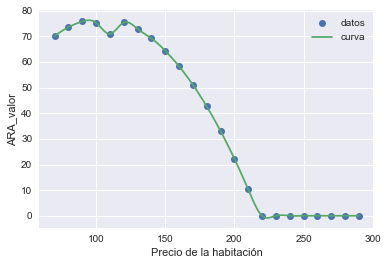

In [29]:
fig = plt.figure()

plt.plot(x_ori, y_ori, 'o', x_new, f(x_new), '-')
plt.legend(['datos', 'curva'], loc='best')
plt.xlabel('Precio de la habitación')
plt.ylabel('ARA_valor')
plt.show()

# fig.savefig("resultados_modo_proactivo.pdf", bbox_inches='tight')

## Test del modelo de regresión
En esta sección se probaran unicamente los resultados obtenidos por el modelo de regresión

In [30]:
lm_test = LinearRegression()
# lm = LogisticRegression()

In [31]:
hotel_data_ni['p0_mean'] = (hotel_data_ni['p0_1'] + hotel_data_ni['p0_2']) / 2

new_x = np.array(list(zip(hotel_data_ni['p'], hotel_data_ni['p0_mean'])))
new_y = hotel_data_ni['outcome_prob'].values

#X_train, X_test, y_train, y_test = train_test_split(new_x, new_y, test_size=0.3, random_state=200)

In [32]:
dummy_y = [5 + 3 * x + 2 * y + 6 * z for x, y, z in zip(range(0,100,2), range(0,200,4), range(0,300,6))]
dummy_x = [[x, y, z] for x, y, z in zip(range(0,100,2), range(0,200,4), range(0,300,6))]
                      
#X_train, X_test, y_train, y_test = dummy_x[:40], dummy_x[40:], dummy_y[:40], dummy_y[40:]

In [33]:
# random_state=317 -> 0.56
# random_state=322 -> 0.55

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.34, random_state=317)

In [34]:
lm_test.fit(X_train, y_train)
predictions = lm_test.predict(X_test)

In [35]:
#pp("------------ PREDICTED ------------")
#pp(list(predictions))
#pp("------------ REAL DATA ------------")
#pp(list(y_test))

In [36]:
lm_test.coef_

array([-0.00649589, -0.00111435,  0.0031938 ])

In [37]:
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, predictions))

Variance score: 0.56
